### Predict whether the resturant will make the profit or not based on the existing dataset.

In [595]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,roc_curve
from imblearn.over_sampling import SMOTE

In [596]:
#Import the data
df= pd.read_csv("C://Users/dubba/Downloads/Github_Repo/Restaurant_Profit_Prediction/restaurant_success.csv")
df

,location,year_3_profit,local_pop,competitors,nearest_fgh,hours,highway,drivethru
0,38195,1,125567.0,0.0,6.4,Extended,3,No
1,12324,1,105571.0,0.0,5.3,24 hours,16,Yes
2,79567,0,104591.0,0.0,6.3,NaN,6,No
3,41435,1,169028.0,0.0,6.0,Extended,5,Yes
4,24969,1,Unknown,0.0,4.5,Extended,4,No drivethru
...,...,...,...,...,...,...,...,...
1085,23969,0,277169.0,0.0,4.5,Regular,22,No
1086,72777,1,17805.0,0.0,14.4,Extended,15,Yes
1087,14249,1,231969.0,0.0,5.2,24 hours,22,No
1088,91866,1,53674.0,0.0,9.4,Extended,9,Yes


In [597]:
#Identify and remove the duplicates
duplicates = df[df.duplicated()]
print(len(duplicates))

#No duplicates exist in the dataset.

df=df.drop('location',axis=1)
#Drop the location column, Since location is a unique identifier for each row and doesnt serve any purpose for our model build 


print("Gather the statistics and check for missing values")
df.info()
print("Identify missing values")
df.isna().sum()

0
Gather the statistics and check for missing values
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1090 entries, 0 to 1089
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year_3_profit  1090 non-null   int64  
 1   local_pop      1090 non-null   object 
 2   competitors    1090 non-null   float64
 3   nearest_fgh    1090 non-null   float64
 4   hours          981 non-null    object 
 5   highway        1090 non-null   int64  
 6   drivethru      1090 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 59.7+ KB
Identify missing values


year_3_profit      0
local_pop          0
competitors        0
nearest_fgh        0
hours            109
highway            0
drivethru          0
dtype: int64

|column name| Details |
|-----------|-----------|
|location   | Discrete. Unique identifier for the restaurant.|
|
|year_3_profit| Nominal. 1 if profitable after 3 years, 0 otherwise.|
|local_pop| Discrete. Population within 30 minutes of travel to the restaurant. Any positive integer.|
|competitors| Discrete. Number of competitor restaurants within 2 kilometers.Any positive integer.|
|nearest_fgh| Continuous. Distance in kilometers to the nearest other Family Grill House location. Any positive value.|
|hours |Ordinal. One of "Regular", "Extended", or "24 hours".|
|highway| Discrete. Travel time in minutes to the nearest highway. Should be at least 1 minute.|
|drivethru |Ordinal. Whether the location has a drive-through order and collection service ("Yes" or "No").|

#### Following are the missing values in the dataset

1) local_pop - Contains Unknown as a value which need to be imputed
2) hours - Contains missing values in the dataset
3) drivethru - Contains No Drivethru as extra category needs to replace it with 'No'
4) highway - It should be positive integer

In [600]:
df['drivethru'] = df['drivethru'].replace('No drivethru','No')
df['drivethru'].unique()

array(['No', 'Yes'], dtype=object)

In [601]:
#Since hours is a categorical value we can use mode imputation
df['hours']=df['hours'].replace(np.nan,df['hours'].mode()[0])

C:\Users\dubba\AppData\Local\Temp\ipykernel_21736\3128283502.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['local_pop'].replace('Unknown',np.nan,inplace=True)


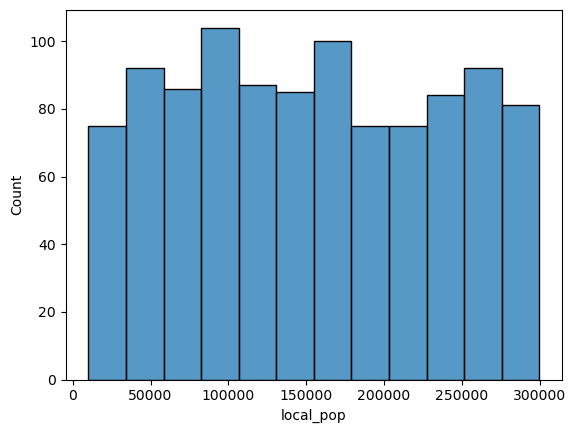

In [602]:
#Replace the Unknown with null value
df['local_pop'].replace('Unknown',np.nan,inplace=True)

#check the distribution and fill the missing values with mean
df['local_pop']=pd.to_numeric(df['local_pop'],errors='coerce')
sns.histplot(data=df['local_pop'])

df['local_pop']=df['local_pop'].replace(np.nan,df['local_pop'].mean())

df['local_pop'] = df['local_pop'].astype(int)

In [603]:
df

,year_3_profit,local_pop,competitors,nearest_fgh,hours,highway,drivethru
0,1,125567,0.0,6.4,Extended,3,No
1,1,105571,0.0,5.3,24 hours,16,Yes
2,0,104591,0.0,6.3,Extended,6,No
3,1,169028,0.0,6.0,Extended,5,Yes
4,1,153471,0.0,4.5,Extended,4,No
...,...,...,...,...,...,...,...
1085,0,277169,0.0,4.5,Regular,22,No
1086,1,17805,0.0,14.4,Extended,15,Yes
1087,1,231969,0.0,5.2,24 hours,22,No
1088,1,53674,0.0,9.4,Extended,9,Yes


<Axes: xlabel='drivethru', ylabel='count'>

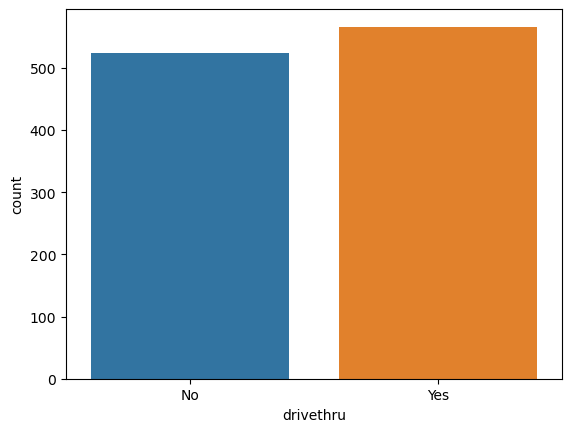

In [604]:
sns.countplot(data=df,x='drivethru',hue='drivethru')

In [605]:
#Handle the non negative values with mean imputation.
df['highway'] = df['highway'].apply(lambda x:round(x) if x>0 else round(df['highway'].mean()))

### Exploratory Data Analysis

<Axes: xlabel='hours', ylabel='count'>

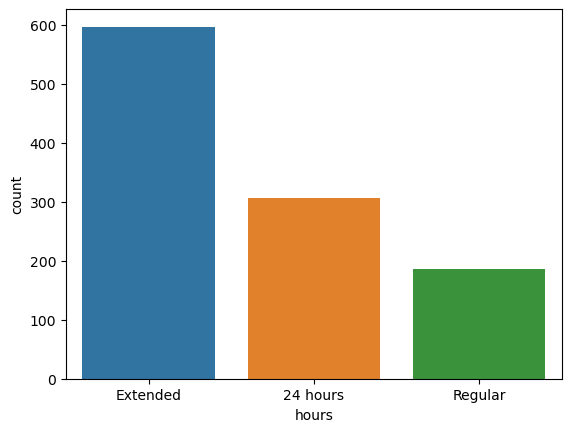

In [607]:
sns.countplot(data=df,x='hours',hue='hours')

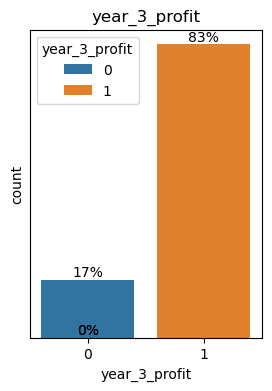

In [608]:

plt.figure(figsize=(3,4))
ax=sns.countplot(x='year_3_profit',hue='year_3_profit',data=df)

ax.set_yticks([])
plt.title("year_3_profit")
total=df['year_3_profit'].count()
for p in ax.patches:
    ax.annotate(format(100*p.get_height()/total, '.0f')+'%', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

plt.show()

Target variable looks imbalanced with 83% as profit and 17% as no-profit

In [610]:
df.describe()

,year_3_profit,local_pop,competitors,nearest_fgh,highway
count,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000
mean,0.834862,153471.838532,0.095413,7.886789,15.059633
std,0.371475,80784.351996,0.293919,7.196412,8.410558
min,0.000000,10044.000000,0.000000,4.000000,1.000000
25%,1.000000,88189.250000,0.000000,5.100000,8.000000
50%,1.000000,153471.000000,0.000000,6.200000,15.000000
75%,1.000000,222588.000000,0.000000,7.400000,22.000000
max,1.000000,299818.000000,1.000000,76.700000,29.000000


C:\Users\dubba\Downloads\Ramanuja\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


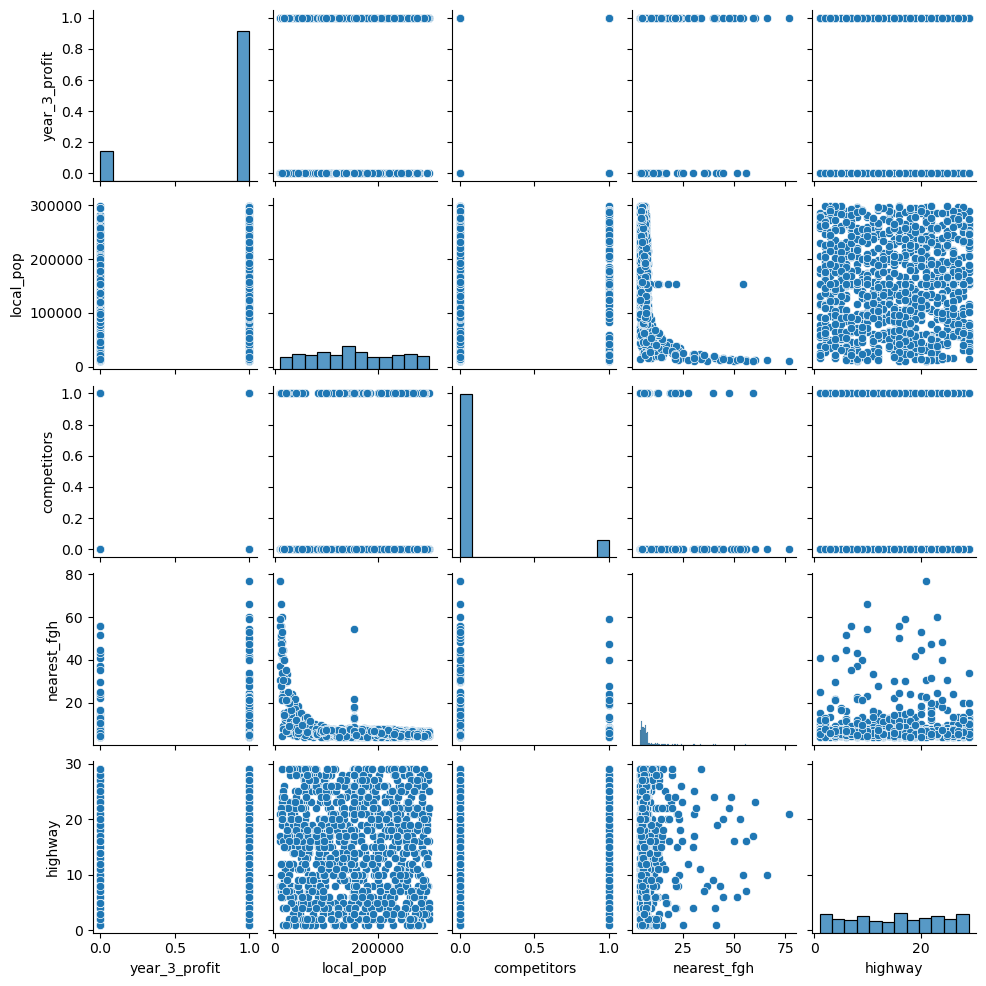

In [611]:
#pairplot
sns.pairplot(data=df,size=2.0)
plt.show()

<Axes: xlabel='nearest_fgh'>

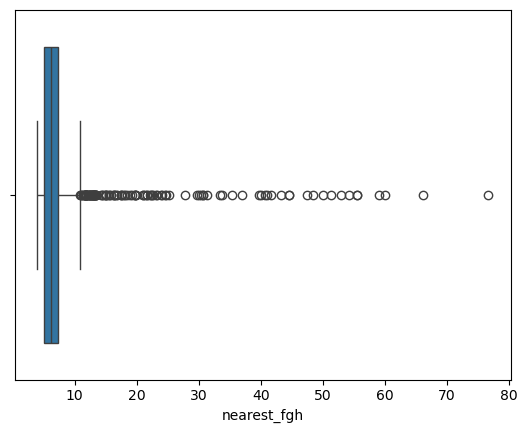

In [612]:
sns.boxplot(data=df,x='nearest_fgh')

In [613]:
#Apply log transformation for the nearest_fgh since the data is skewed
df['nearest_fgh']=np.log(df['nearest_fgh'])
df['local_pop']=np.log(df['local_pop'])

In [614]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1090 entries, 0 to 1089
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year_3_profit  1090 non-null   int64  
 1   local_pop      1090 non-null   float64
 2   competitors    1090 non-null   float64
 3   nearest_fgh    1090 non-null   float64
 4   hours          1090 non-null   object 
 5   highway        1090 non-null   int64  
 6   drivethru      1090 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 59.7+ KB


In [615]:
df

,year_3_profit,local_pop,competitors,nearest_fgh,hours,highway,drivethru
0,1,11.740595,0.0,1.856298,Extended,3,No
1,1,11.567139,0.0,1.667707,24 hours,16,Yes
2,0,11.557813,0.0,1.840550,Extended,6,No
3,1,12.037820,0.0,1.791759,Extended,5,Yes
4,1,11.941267,0.0,1.504077,Extended,4,No
...,...,...,...,...,...,...,...
1085,0,12.532383,0.0,1.504077,Regular,22,No
1086,1,9.787235,0.0,2.667228,Extended,15,Yes
1087,1,12.354359,0.0,1.648659,24 hours,22,No
1088,1,10.890684,0.0,2.240710,Extended,9,Yes


In [616]:
df['competitors'].value_counts()

competitors
0.0    986
1.0    104
Name: count, dtype: int64

In [617]:
#Encode the target variables using Label Encoder.
le =LabelEncoder()

for col in df.columns:
    if df[col].dtype=='object':
        df[col] = le.fit_transform(df[col])
    


<Axes: >

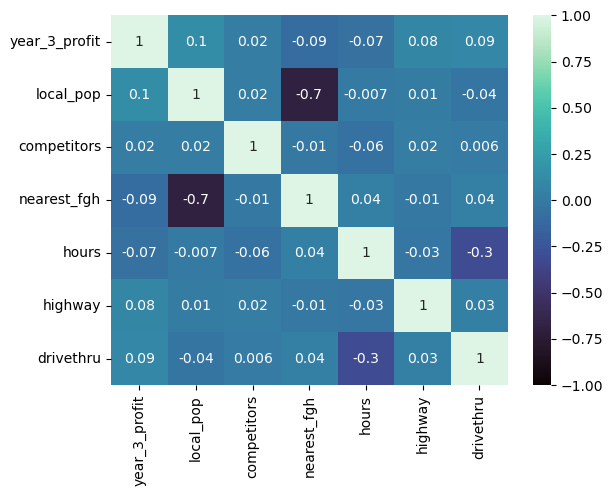

In [618]:
corr = df.corr()
sns.heatmap(data=corr,fmt='.1g',annot=True,vmin=-1,vmax=1,cmap='mako')

##### From the above heatmap we can observe that:
1) Positive correlation between year_3_profit --> local_pop,Drivethru & Location.

2) Negative correlation exist between hours and drivethru, Nearest_fgh and local_pop

In [620]:
#Train Test Split
X= df.drop('year_3_profit',axis=1)
y= df['year_3_profit']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=43)


In [621]:
#Model Build
lgr = LogisticRegression()
lgr.fit(X_train,y_train)
y_pred = lgr.predict(X_test)

#Evaluate the model
print(f'Confusion matrix:\n {confusion_matrix(y_test,y_pred)}')
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion matrix:
 [[  0  56]
 [  0 271]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        56
           1       0.83      1.00      0.91       271

    accuracy                           0.83       327
   macro avg       0.41      0.50      0.45       327
weighted avg       0.69      0.83      0.75       327



C:\Users\dubba\Downloads\Ramanuja\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dubba\Downloads\Ramanuja\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dubba\Downloads\Ramanuja\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


From the output we can observe the results are not accurate because of imbalanced data
Hence we need to balance the target variable

In [623]:
#Handling the imbalance using class weight
class_weights = compute_class_weight('balanced',classes=np.array([1,0]), y=y_train)
print(y.value_counts())
lgr_bal =LogisticRegression(class_weight={0:class_weights[0],1:class_weights[1]})
lgr_bal.fit(X_train,y_train)

y_pred = lgr_bal.predict(X_test)

print(f'Confusion matrix:\n {confusion_matrix(y_test,y_pred)}')
print("\nClassification Report:\n", classification_report(y_test, y_pred))


year_3_profit
1    910
0    180
Name: count, dtype: int64
Confusion matrix:
 [[  0  56]
 [  0 271]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        56
           1       0.83      1.00      0.91       271

    accuracy                           0.83       327
   macro avg       0.41      0.50      0.45       327
weighted avg       0.69      0.83      0.75       327



C:\Users\dubba\Downloads\Ramanuja\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dubba\Downloads\Ramanuja\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dubba\Downloads\Ramanuja\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [624]:
#Handling Imbalance Using SMOTE-Logistic Regression
smote =SMOTE(sampling_strategy='minority' )
X,y=smote.fit_resample(X,y)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=43)
lgr_smote =LogisticRegression()
lgr_smote.fit(X_train,y_train)
y_pred_smote = lgr_smote.predict(X_test)


print("Using Logistic Regression with SMOTE")
print(f'LogisticRegression Model Accuracy: {accuracy_score(y_test, y_pred_smote) * 100:.2f} %')
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))

Using Logistic Regression with SMOTE
LogisticRegression Model Accuracy: 60.07 %
Confusion Matrix:
 [[157 121]
 [ 97 171]]

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.56      0.59       278
           1       0.59      0.64      0.61       268

    accuracy                           0.60       546
   macro avg       0.60      0.60      0.60       546
weighted avg       0.60      0.60      0.60       546



In [625]:
#Using SMOTE-RandomFOrest Classifier

rf_smote =RandomForestClassifier(max_depth=None,max_features='log2',min_samples_leaf=4,min_samples_split=2,n_estimators=50,random_state=42)
rf_smote.fit(X_train,y_train)

y_pred = rf_smote.predict(X_test)

print("Using Random FOrest Classifier with SMOTE")
print(f'Random Forest Model Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} %')
print(f"Confusion Matrix \n",confusion_matrix(y_test,y_pred))
print(f"classification Report\n",classification_report(y_test,y_pred))


Using Random FOrest Classifier with SMOTE
Random Forest Model Accuracy: 77.47 %
Confusion Matrix 
 [[188  90]
 [ 33 235]]
classification Report
               precision    recall  f1-score   support

           0       0.85      0.68      0.75       278
           1       0.72      0.88      0.79       268

    accuracy                           0.77       546
   macro avg       0.79      0.78      0.77       546
weighted avg       0.79      0.77      0.77       546



#### Model Evaluation

Logistic Regression vs Random forest:

1) Random Forest is an ensemble learning method that combines multiple decision trees. This ensemble approach often results in more robust and accurate predictions, reducing overfitting compared to individual decision trees, hence the random forest should fit better than the baseline model logistic or any decion tree model
2) The KPI that can be choosen is accuracy. The accuracy of logistic regression is 60%, while the random forest achieves 78.5%.
3) Printing the classification metrics reveals that the ensemble random forest exhibits better precision, recall, and F1 score.


Definition of a metric for the business to monitor: The metrics we should monitor include model accuracy, precision, recall, and F1 score, as well as the importance of the features on which the target variable depends."

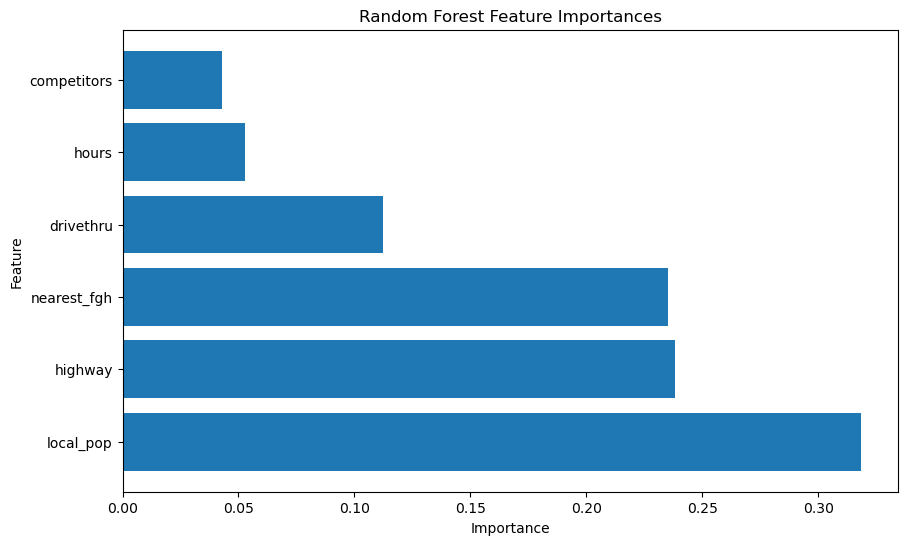

Feature Importances:
       Feature  Importance
0    local_pop    0.318324
4      highway    0.238301
2  nearest_fgh    0.235058
5    drivethru    0.112482
3        hours    0.052886
1  competitors    0.042948


In [627]:
feature_importances = rf_smote.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
import matplotlib.pyplot as plt
# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()

# Display the sorted feature importances
print("Feature Importances:")
print(feature_importance_df)


#### Final Summary/Recommaondations:

- The random forest model can be used to assess the profitability of a new restaurant, as it predicts with an accuracy of 78%.

- The features have dependencies on local_pop (0.31), highway (0.25), and nearest_fgh (0.24). Choose a location with a higher local population, proximity to the highway, and greater distance from other FGH stores. Additionally, stores with extended hours,drivethru tend to be more profitable.

- Continuously improve the model by collecting more data, performing feature engineering, and fine-tuning parameters.